In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import random_split
from sklearn.preprocessing import minmax_scale

In [2]:
data = pd.read_csv('data.csv')
data.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [5]:
colF1 = [col for col in data.columns if col[0:3]=='F_1']
data = data[colF1]
data.head()

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,-1.416075,1.201521,0.551902,-0.759827,NaN
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,-0.853630,0.674525,0.843058,-0.041438,0.259496
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,-0.073235,-1.381605,-0.108676,0.703693,-0.464042
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,-0.618973,0.742112,0.494157,0.744673,-0.769181
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,1.338692,1.193330,1.038010,-0.763692,0.513466


In [7]:
data['F_1_0'].mean(), data['F_1_0'].std()

(-0.0006874779987428729, 1.000784078063498)

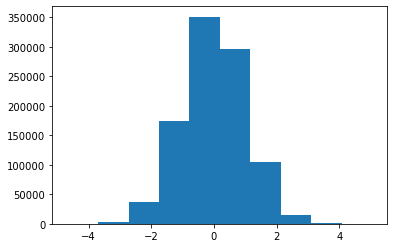

In [8]:
plt.hist(data.values[:,0]);

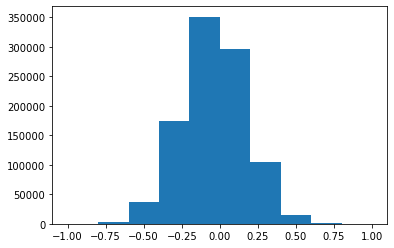

In [11]:
X_norm = minmax_scale(data.values, feature_range=(-1,1), axis=0)
plt.hist(X_norm[:,0]);

In [12]:
X = X_norm[np.sum(np.isnan(X_norm), axis=1)==0]
X.shape

(759506, 15)

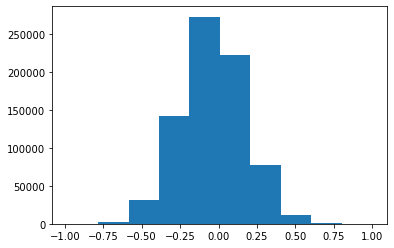

In [13]:
plt.hist(X[:,0]);

In [14]:
class MyDataset(Dataset):
    def __init__(self, X, icol):
        self.X = X
        self.icol = icol
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.Tensor(np.hstack((self.X[idx,:self.icol], self.X[idx,(self.icol+1):]))), torch.Tensor([self.X[idx,self.icol]])

In [15]:
class Model(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.bn2 = nn.BatchNorm1d(hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.bn2(self.activation(self.fc2(x)))
        x = self.bn3(self.activation(self.fc3(x)))
        return nn.Tanh()(self.fc4(x))

In [16]:
def val(model, dataloader):
    criteria = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        loss_mean = 0
        for X, y in dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            loss_mean += loss.item() * X.shape[0]
    return loss_mean / len(dataloader.dataset)

In [19]:
def train(dataset, savename, xmean, epoches=1000, earlystop_patience=10):
    model = Model()
    
    n = len(dataset)
    n1 = int(0.9*n)
    n2 = n - n1
    train_dataset, val_dataset = random_split(dataset, [n1,n2])
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criteria = nn.MSELoss()
    
    for X, y in test_dataloader:
        predict = (xmea)
        
    print(f'starting loss={val(model, train_dataloader)}')
    
    val_loss_min = 100.
    best_epoch = 0
    
    for epoch in range(epoches):
        
        print(f'lr={optimizer.param_groups[0]["lr"]}')
        
        if epoch - best_epoch > earlystop_patience:
            print('early stop')
            break
        
        model.train()

        loss_mean = 0
        for X, y in train_dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * X.shape[0]
        
        loss_mean /= len(train_dataloader.dataset)
        val_loss = val(model, val_dataloader)
        print(f"{datetime.now().strftime('%H:%M:%S')}-epoch {epoch}: training loss={loss_mean}, validation loss={val_loss}")
        scheduler.step(val_loss)
        
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save({'model':model.state_dict()}, savename)

In [45]:
icol = 0
mean_X = X[:,icol].mean()
print(mean_X)
print(f"ref={np.mean(np.square(X[:,icol] - mean_X))}")

-0.038940545705351715
ref=0.042569910975904054


In [ ]:
mydataset = MyDataset(X, icol)
train(mydataset, f'model_dum_{icol}.pickle', xmean)

In [35]:
np.hstack(([1,2,3],[4,5,6],[1]))

array([1, 2, 3, 4, 5, 6, 1])

In [46]:
class MyDataset(Dataset):
    def __init__(self, X, icol):
        self.X = X
        self.icol = icol
        self.meanX = np.mean(self.X[:,icol])
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.Tensor(np.hstack((self.X[idx,:self.icol], self.X[idx,(self.icol+1):], self.meanX))),\
               torch.Tensor([self.X[idx,self.icol]])

In [47]:
mydataset = MyDataset(X, icol)
mydataset[0]

(tensor([-0.1273, -0.1096,  0.3247, -0.1121, -0.2754, -0.0899,  0.2500,  0.0923,
         -0.0529, -0.1881,  0.1213,  0.6887,  0.4524,  0.0353, -0.0389]),
 tensor([0.2460]))

In [48]:
class Model(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.bn2 = nn.BatchNorm1d(hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.bn2(self.activation(self.fc2(x)))
        x = self.bn3(self.activation(self.fc3(x)))
        return nn.Tanh()(self.fc4(x))

In [50]:
icol = 0
mydataset = MyDataset(X, icol)
train(mydataset, f'model_dum_{icol}.pickle')

starting loss=0.045200412295782
lr=0.01
17:58:30-epoch 0: training loss=0.04837054455837761, validation loss=0.043231605150416595
lr=0.01
17:59:25-epoch 1: training loss=0.043252721610526436, validation loss=0.042951291876129775
lr=0.01
18:00:21-epoch 2: training loss=0.04284872158896093, validation loss=0.0425890562084588
lr=0.01
18:01:16-epoch 3: training loss=0.042657227101146604, validation loss=0.0424918020110384
lr=0.01
18:02:12-epoch 4: training loss=0.042590373903043176, validation loss=0.042521536229590685
lr=0.01
18:03:07-epoch 5: training loss=0.04257868905541139, validation loss=0.0424582593887446
lr=0.01
18:04:06-epoch 6: training loss=0.04257852583187323, validation loss=0.04246731408490615
lr=0.01
18:05:01-epoch 7: training loss=0.04257633552356225, validation loss=0.042466385126719346
lr=0.01
18:05:54-epoch 8: training loss=0.04257686606144867, validation loss=0.04246721429312393
lr=0.01
18:06:47-epoch 9: training loss=0.0426098392810056, validation loss=0.0424927058731

KeyboardInterrupt: 

### so this indeed cannot be predicted by the other columns, what about rows??

In [51]:
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,-1.416075,1.201521,0.551902,-0.759827,NaN
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,-0.853630,0.674525,0.843058,-0.041438,0.259496
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,-0.073235,-1.381605,-0.108676,0.703693,-0.464042
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,-0.618973,0.742112,0.494157,0.744673,-0.769181
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,1.338692,1.193330,1.038010,-0.763692,0.513466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,0.569298,0.235662,0.540328,-0.262106,-1.566722
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,-0.040150,-1.235223,0.834497,1.385112,-1.575306
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,-0.874219,0.926165,-0.970726,-1.832919,0.860467
999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,1.362596,-1.469418,0.984130,-1.502292,-0.404490,-0.420554


In [59]:
np.argsort(np.abs(data['F_1_1'].values - data['F_1_1'][0]))

array([     0, 578138, 145814, ..., 795464, 565148, 662840])

In [60]:
data.iloc[578138]

F_1_0    -1.849806
F_1_1    -0.464040
F_1_2     0.672246
F_1_3    -0.951045
F_1_4     1.071388
F_1_5    -0.723347
F_1_6    -0.876403
F_1_7     0.861063
F_1_8     0.320815
F_1_9     0.414444
F_1_10   -0.383463
F_1_11    0.477462
F_1_12    0.823286
F_1_13    1.364030
F_1_14   -1.044247
Name: 578138, dtype: float64

In [72]:
vec = data.values[[1],:] @ data.values.T
vec = vec.reshape(-1)
vec

array([        nan, 13.48005571,         nan, ...,  0.72342095,
       -5.63328045,  2.98405127])

In [75]:
np.argsort(np.abs(vec))

array([748503, 503254, 107870, ..., 706285, 706319,      0])

In [76]:
vec[706319]

nan

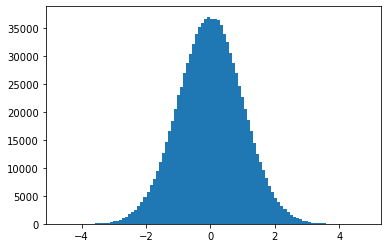

In [94]:
plt.hist(data.values[:,14], bins=100);

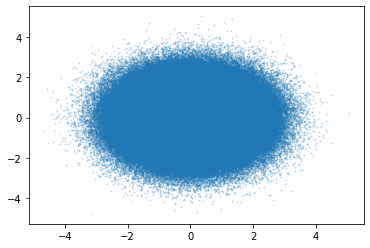

In [98]:
plt.scatter(data.values[:,0],data.values[:,1],s=1,alpha=0.2)